<a href="https://colab.research.google.com/github/HiranMadhu/AgentDashbord/blob/main/hotelReviewsTest1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TripAdvisor Web Scraping with ScraperAPI
This script scrapes hotel reviews from TripAdvisor using ScraperAPI to handle dynamic content and avoid access restrictions.

It starts by loading the main hotel listing page for Sri Lanka and extracts hotel names and their review page links. Then, it loops through each hotel and collects up to 50 reviews by navigating paginated URLs using regex-based offset handling.

Each page is parsed with BeautifulSoup to extract review text from specific HTML elements. A 2-second delay is added between requests to avoid hitting rate limits.

All reviews are stored in a DataFrame and saved to an Excel file (tripadvisor_reviews.xlsx) for further analysis.

**Review Filtering and Cleaning**

This script processes a JSON file of TripAdvisor reviews and filters out only English-language reviews.

It counts the number of reviews per hotel (locationId) and keeps only those with at least 50 English reviews. For each qualifying hotel, up to 50 reviews are selected and stored along with the hotel name.

The filtered data is saved to output_en_filtered.xlsx, and the hotel names are saved to qualified_hotels.txt.

This ensures a clean, balanced dataset ready for sentiment analysis or other downstream tasks.

In [ ]:
# Code for webscraping

import pandas as pd
import requests
from bs4 import BeautifulSoup
import time
import re

# ScraperAPI Key
api_key = "7ad16bbe4b2ecedc8f5dbf59c38e027"

# Get the first page of hotels in Sri Lanka
main_url = "https://www.tripadvisor.com/Hotels-g293961-Sri_Lanka-Hotels.html"
payload_main = {
    "api_key": api_key,
    "url": main_url,
    "render": "true"
}

response_main = requests.get("https://api.scraperapi.com/", params=payload_main)
soup_main = BeautifulSoup(response_main.text, "html.parser")

# Extract hotel names and base review page links
hotels = []
containers = soup_main.find_all("div", class_="XIWnB z y rCDYP")

for tag in containers:
    try:
        link_tag = tag.find("a", href=True)
        if link_tag:
            name = link_tag.get_text(strip=True)
            href = link_tag['href']
            base_url = "https://www.tripadvisor.com" + href.split("#")[0]
            hotels.append({"Name": name, "BaseLink": base_url})
    except Exception as e:
        print("Error processing hotel link:", e)

print(f"Found {len(hotels)} hotels on the first page")

# Loop through each hotel to collect up to 50 reviews
data = []
for idx, hotel in enumerate(hotels):
    print(f"\n[{idx + 1}/{len(hotels)}] Processing: {hotel['Name']}")
    offset = 0
    reviews_collected = 0
    max_reviews = 50

    while reviews_collected < max_reviews:
        try:
            # Construct paginated URL
            paginated_url = re.sub(r"(-Reviews)(-or\d+)?", rf"\1-or{offset}", hotel["BaseLink"])
            payload = {
                "api_key": api_key,
                "url": paginated_url,
                "render": "true"
            }

            response = requests.get("https://api.scraperapi.com/", params=payload)
            soup = BeautifulSoup(response.text, "html.parser")

            # Extract review containers
            review_divs = soup.find_all("div", class_="JVaPo")  # May need adjustment if TripAdvisor changes class names
            if not review_divs:
                print(f"No reviews found at offset {offset}")
                break

            for div in review_divs:
                try:
                    span = div.find("span")
                    if span:
                        review_text = span.get_text(strip=True)
                        if review_text:
                            data.append({
                                "Hotel Name": hotel['Name'],
                                "Review": review_text
                            })
                            reviews_collected += 1
                            if reviews_collected >= max_reviews:
                                break
                except Exception as e:
                    print("Error extracting individual review:", e)

            offset += 5
            time.sleep(2)  # Be respectful of the API and avoid rate limits

        except Exception as e:
            print(f"Error scraping {hotel['Name']} at offset {offset}:", e)
            break

print(f"Total reviews collected: {len(data)}")

# Save collected data to Excel
df = pd.DataFrame(data)
df.to_excel("tripadvisor_reviews.xlsx", index=False)
print("Review data saved to tripadvisor_reviews.xlsx")


In [ ]:
# Reviews cleaning script

import json
from collections import Counter, defaultdict
import pandas as pd

# Load the JSON data
with open('r4.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# Step 1: Filter only English reviews
english_items = [item for item in data if item.get('lang', '') == 'en']

# Step 2: Count reviews per locationId
location_ids = [item.get('locationId') for item in english_items if 'locationId' in item]
location_id_counts = Counter(location_ids)

# Step 3: Get locationIds with more than 49 reviews
qualified_ids = {loc_id for loc_id, count in location_id_counts.items() if count > 49}

# Step 4: Group reviews by locationId
grouped = defaultdict(list)
for item in english_items:
    loc_id = item.get('locationId')
    if loc_id in qualified_ids:
        grouped[loc_id].append(item)

# Step 5: Collect up to 50 reviews per qualified locationId
rows = []
hotel_names = set()
for loc_id, items in grouped.items():
    for item in items[:50]:
        place_name = item.get('placeInfo', {}).get('name', 'Unknown')
        text = item.get('text', '')
        rows.append({
            'Place Name': place_name,
            'Text': text
        })
        hotel_names.add(place_name)

# Step 6: Save to Excel
df = pd.DataFrame(rows)
df.to_excel('output_en_filtered.xlsx', index=False)

# Step 7: Save hotel names to a text file
with open('qualified_hotels.txt', 'w', encoding='utf-8') as f:
    for name in sorted(hotel_names):
        f.write(name + '\n')

print(f"Exported {len(df)} rows to output_en_filtered.xlsx")
print(f"Exported {len(hotel_names)} hotel names to qualified_hotels.txt")

# Requrement installing and load data

In [ ]:
!pip install -q transformers torch
!pip install -q sentence-transformers
!pip install -q transformers datasets
!pip install -q vaderSentiment textblob afinn
!pip install gensim
!pip install -q spacy
!python -m spacy download en_core_web_sm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Place Name,Text
0,Le Grand Galle,Good experience and friendly staff. We had a g...
1,Le Grand Galle,"Fabulous hotel, luxurious. Beautiful view of t..."
2,Le Grand Galle,The pool was lovely and the breakfast was very...
3,Le Grand Galle,Such a perfect choice for any celebration or a...
4,Le Grand Galle,Excellent service. Delicious Food. Room was sp...


**Loading the Hotel Review Data**

This cell mounts Google Drive to access external files and then loads the Excel file containing hotel reviews into a pandas DataFrame. A DataFrame is a two-dimensional data structure used to organize and manipulate data efficiently. Finally, the .head() function displays the first few rows of the dataset to provide an initial overview.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

file_path = '/content/drive/MyDrive/TextAnalytics/hotel88.xlsx'
df = pd.read_excel(file_path)

# Display first few rows
df.head()

# Task 1 - Describe
**Text Preprocessing and Lemmatization**

To prepare the raw review text for analysis, a two-step preprocessing approach is applied: lemmatization followed by text cleaning.

Lemmatization reduces words to their base forms by using the spaCy language model. This helps reduce vocabulary size and improve generalization. Only alphabetic, non-stopword tokens are retained.

Text cleaning removes unwanted characters and formatting by:

* Lowercasing the text

* Removing HTML tags, digits, and punctuation

* Normalizing whitespace

The final cleaned text is stored in a new column and used for downstream tasks such as vectorization and classification.

In [ ]:
import re
import string
import spacy
nlp = spacy.load("en_core_web_sm")

# Clean review text
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)  # remove any HTML tags
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation marks
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Preprocessing function with lemmatization
def preprocess_with_lemmatization(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    return " ".join(tokens)

# Apply lematization
df['cleaned_review'] = df['Text'].apply(preprocess_with_lemmatization)

# Apply cleening
df['Cleaned_Text'] = df['cleaned_review'].apply(clean_text)

# Preview the clean lists
df[['Text', 'Cleaned_Text']].head()


,Text,Cleaned_Text
0,Good experience and friendly staff. We had a g...,good experience and friendly staff we had a gr...
1,"Fabulous hotel, luxurious. Beautiful view of t...",fabulous hotel luxurious beautiful view of the...
2,The pool was lovely and the breakfast was very...,the pool was lovely and the breakfast was very...
3,Such a perfect choice for any celebration or a...,such a perfect choice for any celebration or a...
4,Excellent service. Delicious Food. Room was sp...,excellent service delicious food room was spac...


**Dataset Overview and Statistics**

This cell performs basic exploratory analysis to understand the dataset structure. The operations include:

*  Counting the number of unique hotels.

*  Determining the total number of reviews.

*  Calculating the word count for each review.

*  Aggregating the total word count across the dataset.

*  Identifying the number of unique words in the dataset.

These statistics provide insight into the scale, richness, and diversity of the textual data.



In [ ]:
# Number of hotels
num_hotels = df['Place Name'].nunique()

# Number of reviews
total_reviews = df.shape[0]

# Reviews per hotel
reviews_per_hotel = df['Place Name'].value_counts()

# Tokenize to count words
df['Word_Count'] = df['Cleaned_Text'].apply(lambda x: len(x.split()))

# Total number of words
total_words = df['Word_Count'].sum()

# Unique words
all_words = ' '.join(df['Cleaned_Text']).split()
unique_words = set(all_words)
num_unique_words = len(unique_words)

print(f"Number of hotels: {num_hotels}")
print(f"Total number of reviews: {total_reviews}")
print(f"Total number of words: {total_words}")
print(f"Number of unique words: {num_unique_words}")


Number of hotels: 86
Total number of reviews: 4400
Total number of words: 368493
Number of unique words: 14868


**Review Length Distribution**

A histogram is generated to visualize the distribution of word counts in the reviews. This plot highlights the variation in review lengths, helping to identify whether reviews tend to be short, long, or spread across a wide range. Such visualization supports decisions around text truncation and padding in further processing

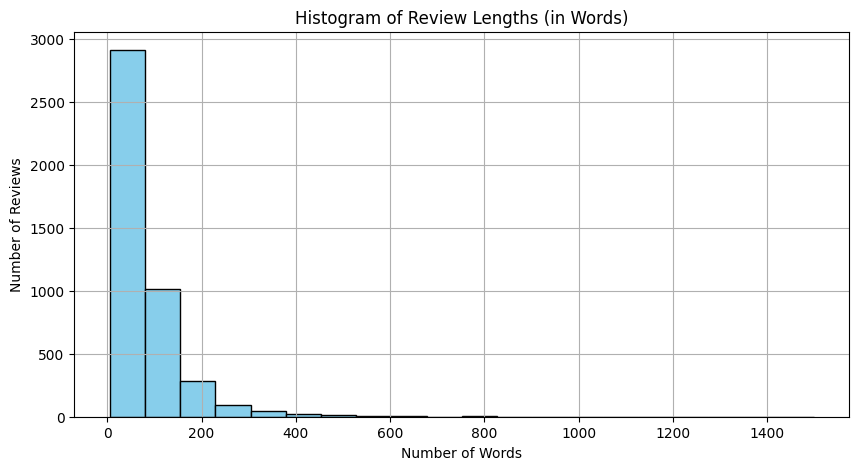

In [ ]:
#Histogram of Review Lengths

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(df['Word_Count'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Review Lengths (in Words)')
plt.xlabel('Number of Words')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()


**Common Word Frequency Analysis**

This section identifies the most frequently used words in the cleaned text data. A word frequency count is performed, and the top 20 most common words are visualized. This helps in identifying recurring themes or vocabulary, although high-frequency generic terms (like stop words) may dominate unless filtered.

In [ ]:
from collections import Counter

# Flat the list
word_list = [word for review in df['Cleaned_Text'] for word in review.split()]
common_words = Counter(word_list).most_common(20)

# Display top 20
for word, freq in common_words:
    print(f"{word}: {freq}")


the: 23548
and: 17090
a: 9878
to: 8988
was: 7977
we: 5781
of: 5450
is: 4715
in: 4444
for: 4337
with: 3950
hotel: 3623
very: 3610
staff: 3267
our: 3186
were: 3049
i: 2861
at: 2762
it: 2658
stay: 2442


**N-gram Analysis**

This step explores collocated terms using n-gram models:

* Bigrams (two-word combinations)

* Trigrams (three-word combinations)

Stop words are excluded to focus on meaningful phrase structures. This method captures frequently used expressions such as "friendly staff" or "great location," which are important for identifying sentiment and topics. The most common n-grams are visualized for better interpretability.

Top 10 Bigrams:
sri lanka: 581
highly recommend: 406
staff friendly: 342
sri lankan: 325
friendly helpful: 221
highly recommended: 210
recommend hotel: 193
friendly staff: 180
special thanks: 178
food delicious: 174

Top 10 Trigrams:
staff friendly helpful: 96
highly recommend hotel: 81
tour sri lanka: 40
staff incredibly friendly: 39
trip sri lanka: 36
highly recommend place: 35
food absolutely delicious: 33
staff friendly attentive: 32
rooms spacious clean: 31
really enjoyed stay: 31


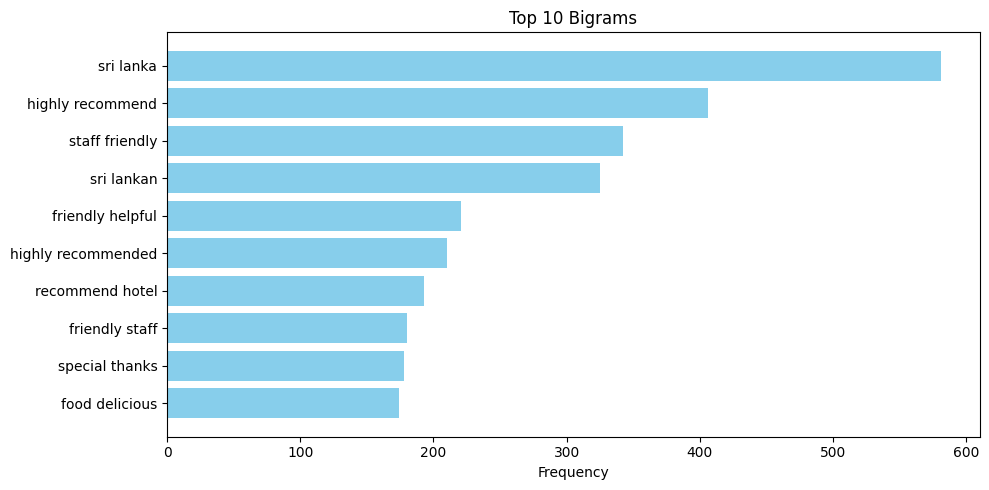

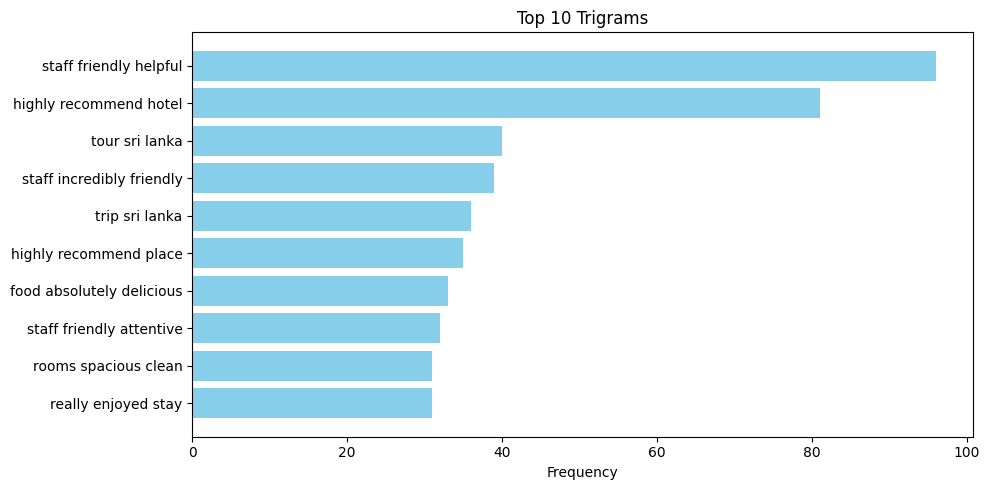

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import matplotlib.pyplot as plt

# Extract top n-grams
def get_top_ngrams(corpus, ngram_range=(2,2), n=None):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    bag_of_words = vec.fit_transform(corpus)
    sum_words = bag_of_words.sum(axis=0)

    # Get phrase -> count dictionary
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    return words_freq[:n]

# Plot n-gram frequencies
def plot_ngrams(ngrams, title):
    phrases, freqs = zip(*ngrams)
    plt.figure(figsize=(10, 5))
    plt.barh(phrases[::-1], freqs[::-1], color='skyblue')
    plt.title(title)
    plt.xlabel('Frequency')
    plt.tight_layout()
    plt.show()

top_bigrams = get_top_ngrams(df['Cleaned_Text'], ngram_range=(2,2), n=10)
top_trigrams = get_top_ngrams(df['Cleaned_Text'], ngram_range=(3,3), n=10)

print("Top 10 Bigrams:")
for phrase, freq in top_bigrams:
    print(f"{phrase}: {freq}")

print("\nTop 10 Trigrams:")
for phrase, freq in top_trigrams:
    print(f"{phrase}: {freq}")

plot_ngrams(top_bigrams, "Top 10 Bigrams")
plot_ngrams(top_trigrams, "Top 10 Trigrams")


# Task 2 - Establishing Ground Truth
**Sentiment Labeling Using Majority Voting**

This cell performs sentiment analysis using three pre-built lexicon-based tools:

* VADER: Optimized for social media and short informal text.

* TextBlob: Provides polarity and subjectivity scores.

* AFINN: Assigns integer sentiment scores to words.

Each tool produces a sentiment label for every review. A majority voting system is applied where the final sentiment label is assigned based on at least two out of the three agreeing. This ensemble approach increases reliability and robustness in the sentiment labeling process.

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from afinn import Afinn
import numpy as np

vader = SentimentIntensityAnalyzer()
afinn = Afinn()

def get_vader_sentiment(text):
    score = vader.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

def get_textblob_sentiment(text):
    score = TextBlob(text).sentiment.polarity
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

def get_afinn_sentiment(text):
    score = afinn.score(text)
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply the funcs above
df['VADER_Label'] = df['Cleaned_Text'].apply(get_vader_sentiment)
df['TextBlob_Label'] = df['Cleaned_Text'].apply(get_textblob_sentiment)
df['AFINN_Label'] = df['Cleaned_Text'].apply(get_afinn_sentiment)

# Majority Voting Function
def majority_vote(row):
    votes = [row['VADER_Label'], row['TextBlob_Label'], row['AFINN_Label']]
    vote_counts = {label: votes.count(label) for label in set(votes)}
    return max(vote_counts, key=vote_counts.get)

df['Final_Sentiment_Label'] = df.apply(majority_vote, axis=1)


df[['Cleaned_Text', 'VADER_Label', 'TextBlob_Label', 'AFINN_Label', 'Final_Sentiment_Label']].head()
df['Final_Sentiment_Label'].value_counts()

,count
Final_Sentiment_Label,
positive,4291
negative,99
neutral,10


There exists a significant class imbalance in the sentiment labels of the dataset. A large majority of the reviews are classified as positive (4,291 instances), while negative and neutral sentiments are heavily underrepresented, with only 99 and 10 instances respectively. This distribution indicates a strong skew toward positive experiences in the collected hotel reviews, which is reasonable in real-world scenarios where users are more likely to leave reviews after pleasant stays.

However, this imbalance should be carefully considered when training and evaluating any sentiment classification models. A model may appear to perform well overall simply by predicting the majority class (positive) frequently, while failing to correctly identify the minority classes (negative and neutral). Therefore, evaluation metrics such as precision, recall, and F1-score per class will be crucial to obtain a fair understanding of the model’s performance, especially on the underrepresented sentiment classes.

# Task 3 - Feature Extraction

**Text Vectorization Techniques**

Since machine learning models require numerical input, textual data is transformed into feature vectors. Four different vectorization methods are applied:

* CountVectorizer: Captures raw word frequencies.

* TF-IDF: Weighs word frequencies by their inverse document frequency to reduce the impact of common terms.

* GloVe Embeddings: Utilizes pre-trained dense word vectors capturing semantic meaning.

* Word2Vec Embeddings: Trains custom dense embeddings on the current dataset to learn domain-specific representations.

The shapes of the resulting feature matrices are printed to show the dimensionality of each representation.

In [ ]:
# Task 3: Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
from gensim.models import Word2Vec



# Bag-of-Words (CountVectorizer)
count_vectorizer = CountVectorizer(max_features=5000)
X_count = count_vectorizer.fit_transform(df['Cleaned_Text'])

print("Shape of Count Vectorizer (BoW) matrix:", X_count.shape)

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['Cleaned_Text'])

print("Shape of TF-IDF matrix:", X_tfidf.shape)

embeddings_index = {}
with open("/content/drive/MyDrive/TextAnalytics/glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

def get_glove_vector(text, embeddings_index, dim=100):
    words = text.split()
    valid_vectors = [embeddings_index[word] for word in words if word in embeddings_index]
    if valid_vectors:
        return np.mean(valid_vectors, axis=0)
    else:
        return np.zeros(dim)

# Apply to all rows
glove_vectors = np.vstack(df['Cleaned_Text'].apply(lambda x: get_glove_vector(x, embeddings_index)).values)
print("Shape of GloVe Embedding matrix:", glove_vectors.shape)


tokenized_reviews = df['Cleaned_Text'].apply(lambda x: x.split())

w2v_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=2, workers=4)

def get_w2v_vector(words, model, dim=100):
    valid_vectors = [model.wv[word] for word in words if word in model.wv]
    if valid_vectors:
        return np.mean(valid_vectors, axis=0)
    else:
        return np.zeros(dim)


w2v_vectors = np.vstack(tokenized_reviews.apply(lambda x: get_w2v_vector(x, w2v_model)))

print("Shape of Word2Vec matrix:", w2v_vectors.shape)


# ------------------- Summary -------------------

print("\n--- Task 3 Summary ---")
print("Sparse Feature Sets:")
print(" - CountVectorizer: {} features".format(X_count.shape[1]))
print(" - TF-IDF: {} features".format(X_tfidf.shape[1]))
print("Dense Feature Sets:")
print(" - GloVe: 100 features (pre-trained)")
print(" - Word2Vec: 100 features (trained on our data)")


Shape of Count Vectorizer (BoW) matrix: (4400, 5000)
Shape of TF-IDF matrix: (4400, 5000)
Shape of GloVe Embedding matrix: (4400, 100)
Shape of Word2Vec matrix: (4400, 100)

--- Task 3 Summary ---
Sparse Feature Sets:
 - CountVectorizer: 5000 features
 - TF-IDF: 5000 features
Dense Feature Sets:
 - GloVe: 100 features (pre-trained)
 - Word2Vec: 100 features (trained on our data)


# Task 4 - Text classification
**Sentiment Classification with Traditional ML Models**

This step involves training classical machine learning models for sentiment classification. The models include:

* Naive Bayes

* Logistic Regression

* Support Vector Machine (SVM)

Each model is trained using different vector representations (CountVectorizer, TF-IDF, GloVe, Word2Vec). The dataset is split into training and testing sets, and the models are evaluated using accuracy, precision, recall, and F1-score. This allows for comparison across models and vectorization techniques.

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['Final_Sentiment_Label'])

feature_sets = {
    'CountVectorizer': X_count,
    'TFIDF': X_tfidf,
    'GloVe': glove_vectors,
    'Word2Vec': w2v_vectors
}

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

classifiers = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': LinearSVC()
}

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

all_results = []


for feature_name, X in feature_sets.items():
    X_train, X_test, y_train, y_test = train_test_split(X, df['encoded_label'], test_size=0.2, random_state=42)
    for clf_name, clf in classifiers.items():
        if clf_name == 'Naive Bayes' and (feature_name in ['GloVe', 'Word2Vec']):
            continue
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True, target_names=label_encoder.classes_)
        conf_matrix = confusion_matrix(y_test, y_pred)
        all_results.append({
            'Feature': feature_name,
            'Classifier': clf_name,
            'Accuracy': report['accuracy'],
            'Precision (macro avg)': report['macro avg']['precision'],
            'Recall (macro avg)': report['macro avg']['recall'],
            'F1-score (macro avg)': report['macro avg']['f1-score'],
            'Confusion Matrix': conf_matrix
        })

# Convert the result list into a pandas DataFrame
results_df = pd.DataFrame(all_results)
results_df[['Feature', 'Classifier', 'Accuracy', 'Precision (macro avg)', 'Recall (macro avg)', 'F1-score (macro avg)']]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/s

,Feature,Classifier,Accuracy,Precision (macro avg),Recall (macro avg),F1-score (macro avg)
0,CountVectorizer,Naive Bayes,0.981818,0.563295,0.624676,0.590274
1,CountVectorizer,Logistic Regression,0.976136,0.921635,0.556516,0.645918
2,CountVectorizer,SVM,0.975000,0.904167,0.556124,0.641250
3,TFIDF,Naive Bayes,0.965909,0.321970,0.333333,0.327553
4,TFIDF,Logistic Regression,0.965909,0.321970,0.333333,0.327553
5,TFIDF,SVM,0.973864,0.991218,0.493590,0.587217
6,GloVe,Logistic Regression,0.965909,0.489346,0.358190,0.371984
7,GloVe,SVM,0.970455,0.853037,0.504842,0.584620
8,Word2Vec,Logistic Regression,0.970455,0.601576,0.397044,0.432473
9,Word2Vec,SVM,0.969318,0.590095,0.384223,0.414137


# Task 5 - Using pre-trained vectors
**Sentence Embeddings with Sentence-BERT**

This section introduces an advanced embedding technique using Sentence-BERT, which encodes entire sentences into dense vectors. These embeddings are expected to capture contextual and semantic relationships better than word-level methods. The same classifiers (Logistic Regression, SVM, Naive Bayes) are trained on these embeddings. Evaluation metrics are computed to compare performance with previous approaches.

In [ ]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score


label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Final_Sentiment_Label'])

X_text = df['Cleaned_Text'].astype(str).tolist()
y = df['Encoded_Label']


model = SentenceTransformer('all-MiniLM-L6-v2')
X_embeddings = model.encode(X_text, show_progress_bar=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y, test_size=0.2, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='linear'),
    "Naive Bayes": MultinomialNB()
}


for name, clf in models.items():
    if name == "Naive Bayes":
        min_val = np.min(X_train)
        X_train_nb = X_train - min_val
        X_test_nb = X_test - min_val
        clf.fit(X_train_nb, y_train)
        preds = clf.predict(X_test_nb)
    else:
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)

    print(f"\n{name} with Sentence-BERT Embeddings:")
    print("Accuracy:", accuracy_score(y_test, preds))
    print(classification_report(y_test, preds, target_names=label_encoder.classes_))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/138 [00:00<?, ?it/s]


Logistic Regression with Sentence-BERT Embeddings:
Accuracy: 0.9727272727272728
              precision    recall  f1-score   support

    negative       0.80      0.31      0.44        26
     neutral       0.00      0.00      0.00         4
    positive       0.97      1.00      0.99       850

    accuracy                           0.97       880
   macro avg       0.59      0.44      0.48       880
weighted avg       0.97      0.97      0.97       880



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



SVM with Sentence-BERT Embeddings:
Accuracy: 0.9727272727272728
              precision    recall  f1-score   support

    negative       1.00      0.23      0.38        26
     neutral       0.00      0.00      0.00         4
    positive       0.97      1.00      0.99       850

    accuracy                           0.97       880
   macro avg       0.66      0.41      0.45       880
weighted avg       0.97      0.97      0.96       880


Naive Bayes with Sentence-BERT Embeddings:
Accuracy: 0.9659090909090909
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        26
     neutral       0.00      0.00      0.00         4
    positive       0.97      1.00      0.98       850

    accuracy                           0.97       880
   macro avg       0.32      0.33      0.33       880
weighted avg       0.93      0.97      0.95       880



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

**Topic Modeling with LDA**

Topic modeling is performed using Latent Dirichlet Allocation (LDA) to identify common themes across reviews. The model is configured to detect five latent topics. Each topic is represented by a set of top keywords, and each review is assigned a dominant topic. This provides an unsupervised approach to aspect discovery, grouping semantically similar reviews based on content.

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import tensorflow as tf
from sklearn.model_selection import train_test_split


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

df['Encoded_Label'] = label_encoder.fit_transform(df['Final_Sentiment_Label'])

def convert_data(df, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []
    labels = []

    for sent, label in zip(df['Cleaned_Text'], df['Encoded_Label']):
        enc = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(enc['input_ids'])
        attention_masks.append(enc['attention_mask'])
        labels.append(label)

    return (
        tf.concat(input_ids, axis=0),
        tf.concat(attention_masks, axis=0),
        tf.convert_to_tensor(labels)
    )


train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Cleaned_Text'], df['Encoded_Label'], test_size=0.2, random_state=42
)

train_df = pd.DataFrame({'Cleaned_Text': train_texts, 'Encoded_Label': train_labels})
val_df = pd.DataFrame({'Cleaned_Text': val_texts, 'Encoded_Label': val_labels})

train_input_ids, train_attention_masks, train_labels = convert_data(train_df, tokenizer)
val_input_ids, val_attention_masks, val_labels = convert_data(val_df, tokenizer)

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

history = model.fit(
    [train_input_ids, train_attention_masks], train_labels,
    validation_data=([val_input_ids, val_attention_masks], val_labels),
    epochs=2, batch_size=16
)


# Task 6 - Text Clustering as a Proxy for Ground Truth
**Aspect-Based Sentiment Classification Setup**

This cell connects topic modeling with sentiment analysis to lay the foundation for Aspect-Based Sentiment Analysis (ABSA). Key operations include:

* Validating topic assignments against a manually labeled sample of reviews with specific aspects.

* Mapping topic numbers to meaningful aspect names.

* Preparing feature-target pairs using the identified aspect labels and final sentiment labels.

* Training a classification model (e.g., Logistic Regression) to predict sentiment in the context of identified aspects.

This enables more nuanced analysis by determining not just how customers feel, but what specific hotel aspects their sentiments are directed at.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

count_vectorizer = CountVectorizer(max_df=0.95, min_df=5, stop_words='english')
dtm = count_vectorizer.fit_transform(df['Cleaned_Text'])

num_topics = 5

lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)

def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        print(", ".join(top_words))
        print()

num_top_words = 10
feature_names = count_vectorizer.get_feature_names_out()
display_topics(lda, feature_names, num_top_words)

doc_topic_dist = lda.transform(dtm)
df['Dominant_Topic'] = np.argmax(doc_topic_dist, axis=1)
print(df[['Cleaned_Text', 'Dominant_Topic']].head())


topic_labels = {
    0: "Rooms & Facilities",
    1: "Service & Experience",
    2: "Staff & Cleanliness",
    3: "Safari & Activities",
    4: "Food & Dining"
    }

df['Aspect_Label'] = df['Dominant_Topic'].map(topic_labels)
df[['Cleaned_Text', 'Dominant_Topic', 'Aspect_Label']].head()


Topic 1:
hotel, room, staff, pool, rooms, breakfast, food, sri, beach, great

Topic 2:
stay, experience, truly, service, staff, special, team, hospitality, feel, thank

Topic 3:
staff, hotel, great, food, good, stay, service, friendly, nice, clean

Topic 4:
amazing, safari, food, experience, stay, pool, guide, yala, great, lake

Topic 5:
hotel, staff, service, experience, room, manager, food, time, restaurant, stay

                                        Cleaned_Text  Dominant_Topic
0  good experience and friendly staff we had a gr...               2
1  fabulous hotel luxurious beautiful view of the...               2
2  the pool was lovely and the breakfast was very...               2
3  such a perfect choice for any celebration or a...               1
4  excellent service delicious food room was spac...               2


,Cleaned_Text,Dominant_Topic,Aspect_Label
0,good experience and friendly staff we had a gr...,2,Staff & Cleanliness
1,fabulous hotel luxurious beautiful view of the...,2,Staff & Cleanliness
2,the pool was lovely and the breakfast was very...,2,Staff & Cleanliness
3,such a perfect choice for any celebration or a...,1,Service & Experience
4,excellent service delicious food room was spac...,2,Staff & Cleanliness


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer

manual_df = pd.read_csv('/content/drive/MyDrive/TextAnalytics/sample_50_reviews.csv')

comparison_df = pd.merge(manual_df, df[['Cleaned_Text', 'Dominant_Topic']], on='Cleaned_Text', how='inner')
print("Validation of Manual Aspects vs Predicted Dominant Topics:")
print(pd.crosstab(comparison_df['Manual_Aspect'], comparison_df['Dominant_Topic']))

topic_to_aspect = {
    1: 'Food',
    2: 'Staff',
    3: 'Service',
    4: 'Experience',
    5: 'Hotel Facilities'
}
df['Aspect_Label'] = df['Dominant_Topic'].map(topic_to_aspect)

X = df['Cleaned_Text']
sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2}
y = df['Final_Sentiment_Label'].map(sentiment_map)

tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print("\nAspect-based Sentiment Classification Results:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Validation of Manual Aspects vs Predicted Dominant Topics:
Dominant_Topic  0  1  2  3  4
Manual_Aspect                
0               9  6  8  0  0
1               1  0  4  0  0
2               3  1  9  1  1
3               1  0  0  0  0
4               0  0  5  1  3

Aspect-based Sentiment Classification Results:
Accuracy: 0.9659
Precision: 0.9330
Recall: 0.9659
F1-Score: 0.9492


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
